# Large area utilities

Many times we would like to run algorithms for large geographical areas. However due to large amount of data we probably won't have enough working memory to do that all at once. So we need to split the area into smaller parts and properly manage them. To make this easier `sentinelhub` package implements utilities for splitting areas into smaller bounding boxes.

## Prerequisites

### Imports

In [50]:
%matplotlib inline

import itertools
import tempfile
from pathlib import Path

import numpy as np
from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
)

The following packages are not included or required for `sentinelhub` package however they are used in this example notebook. In case you would like to reproduce some visualizations you will have to install them separately.

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap

### Collecting data

To start we need a geometry of the area of interest. The `sentinelhub` package uses the `shapely` package to work with geometries. Therefore any geometry inputs need to be an instance of `shapely.geometry.multipolygon.MultiPolygon` or `shapely.geometry.polygon.Polygon`.

In these examples we will use a geometry of [Hawaii islands](https://en.wikipedia.org/wiki/Hawaiian_Islands).

In [3]:
INPUT_FILE = "./data/Hawaii.json"

geo_json = read_data(INPUT_FILE)
hawaii_area = shape(geo_json["features"][0]["geometry"])

type(hawaii_area)

shapely.geometry.multipolygon.MultiPolygon

Let's check how the area looks on the world map.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


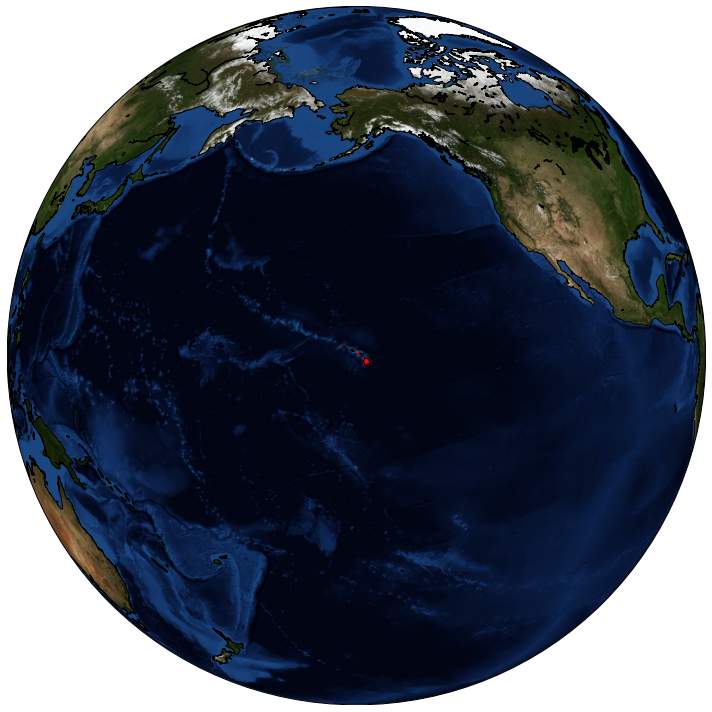

In [4]:
def show_area(area_shape, area_buffer=0.3):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    minx, miny, maxx, maxy = area_shape.bounds
    lng, lat = (minx + maxx) / 2, (miny + maxy) / 2

    m = Basemap(projection="ortho", lat_0=lat, lon_0=lng, resolution="l")
    m.drawcoastlines()
    m.bluemarble()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        x, y = np.array(polygon.boundary.coords)[0]
        m_poly = []
        for x, y in np.array(polygon.boundary.coords):
            m_poly.append(m(x, y))
        ax.add_patch(plt_polygon(np.array(m_poly), closed=True, facecolor="red", edgecolor="red"))

    plt.tight_layout()
    plt.show()


show_area(hawaii_area)

## Area Splitting

We would like to split the area into smaller bounding boxes which could them be used for obtaining data by calling WMS/WCS requests. The package implements 3 different ways of splitting the area.

### Splitting the bounding box

The most straight forward approach is to calculate the area bounding box and split it into smaller parts of equal size.

As an input we need to provide a list of geometries, their CRS, and `int` or `tuple` specifying to how many parts bounding box will be split. 

In [21]:
bbox_splitter = BBoxSplitter(
    [hawaii_area], CRS.WGS84, (5, 4)
)  # bounding box will be split into grid of 5x4 bounding boxes

print("Area bounding box: {}\n".format(bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created.\nExample:\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

Area bounding box: BBox(((-159.764448, 18.948267), (-154.807817, 22.228955)), crs=CRS('4326'))

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((-159.764448, 21.408783), (-158.77312179999998, 22.228955)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((-159.764448, 18.948267), (-154.807817, 22.228955)), crs=CRS('4326')), 'index_x': 0, 'index_y': 3}



Besides the list of bounding boxes it is also possible to get a list of geometries (i.e. intersection of each bounding box with entire area of interest).

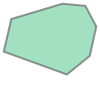

In [22]:
geometry_list = bbox_splitter.get_geometry_list()

geometry_list[0]

In order to visualize the splits let's use the following function

In [12]:
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    area_bbox = splitter.get_area_bbox()
    minx, miny, maxx, maxy = area_bbox
    lng, lat = area_bbox.middle
    w, h = maxx - minx, maxy - miny
    minx = minx - area_buffer * w
    miny = miny - area_buffer * h
    maxx = maxx + area_buffer * w
    maxy = maxy + area_buffer * h

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    base_map = Basemap(
        projection="mill",
        lat_0=lat,
        lon_0=lng,
        llcrnrlon=minx,
        llcrnrlat=miny,
        urcrnrlon=maxx,
        urcrnrlat=maxy,
        resolution="l",
        epsg=4326,
    )
    base_map.drawcoastlines(color=(0, 0, 0, 0))

    area_shape = splitter.get_area_shape()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        if isinstance(polygon.boundary, MultiLineString):
            for linestring in polygon.boundary:
                ax.add_patch(plt_polygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red"))
        else:
            ax.add_patch(
                plt_polygon(np.array(polygon.boundary.coords), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red")
            )

    bbox_list = splitter.get_bbox_list()
    info_list = splitter.get_info_list()

    cm = plt.get_cmap("jet", len(bbox_list))
    legend_shapes = []
    for i, (bbox, info) in enumerate(zip(bbox_list, info_list)):
        wgs84_bbox = bbox.transform(CRS.WGS84).get_polygon()

        tile_color = tuple(list(cm(i))[:3] + [alpha])
        ax.add_patch(plt_polygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor="green"))

        if show_legend:
            legend_shapes.append(plt.Rectangle((0, 0), 1, 1, fc=cm(i)))

    if show_legend:
        legend_names = []
        for info in info_list:
            legend_name = "{},{}".format(info["index_x"], info["index_y"])

            for prop in ["grid_index", "tile"]:
                if prop in info:
                    legend_name = "{},{}".format(info[prop], legend_name)

            legend_names.append(legend_name)

        plt.legend(legend_shapes, legend_names)
    plt.tight_layout()
    plt.show()

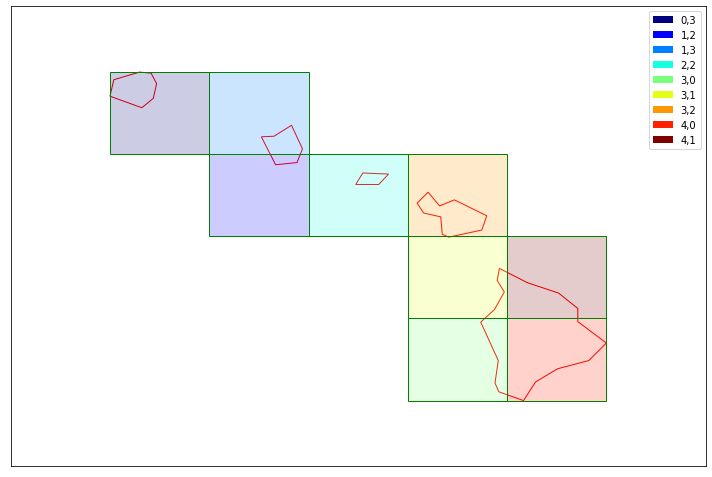

In [24]:
show_splitter(bbox_splitter, show_legend=True)

Splitter automatically removed the bounding boxes that did not intersect with the geometry of Hawaii Islands. However the majority of the area inside bounding boxes is still outside our geometry. Therefore each splitter has also an optional parameter `reduce_bbox_sizes`.

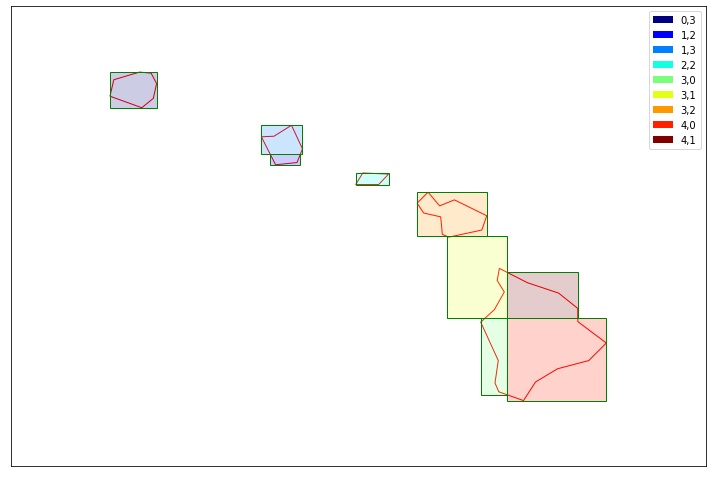

In [25]:
bbox_splitter_reduced = BBoxSplitter([hawaii_area], CRS.WGS84, (5, 4), reduce_bbox_sizes=True)

show_splitter(bbox_splitter_reduced, show_legend=True)

By specifying finer splitting we could even further reduce the total area of bounding boxes.


### Splitting in OSM grid

Sometimes it is better to have a splitting grid independent from the given geometries. That way if the geometries at some point slightly change the grid will stay the same.

The following splitter implements [Open Street Map's grid](https://wiki.openstreetmap.org/wiki/Slippy_Map).

In [26]:
osm_splitter = OsmSplitter([hawaii_area], CRS.WGS84, zoom_level=10)

print(repr(osm_splitter.get_bbox_list()[0]))
print(osm_splitter.get_info_list()[0])

BBox(((-159.96093749999997, 21.616579336740603), (-159.609375, 21.943045533438177)), crs=CRS('4326'))
{'zoom_level': 10, 'index_x': 57, 'index_y': 448}


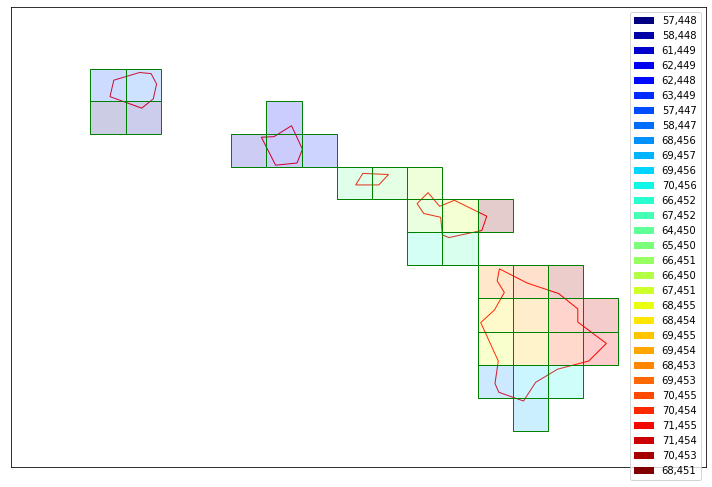

In [27]:
show_splitter(osm_splitter, show_legend=True)

### Splitting in satellite's tile grid

If we would like to work on a level of satellite tiles and split them we can use the `TileSplitter`. It works in combination with Sentinel Hub WFS service therefore an instance ID is required, as described in [instruction](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). We also need to specify `time_interval` and `data_collection`.

In [28]:
from sentinelhub import SHConfig

config = SHConfig()

if config.instance_id == "":
    print("Warning! To use WFS functionality, please configure the `instance_id`.")

In [41]:
tile_splitter = TileSplitter(
    [hawaii_area], CRS.WGS84, ("2017-10-01", "2017-11-01"), data_collection=DataCollection.SENTINEL2_L1C, config=config
)

tile_bbox_list = tile_splitter.get_bbox_list()

print(len(tile_bbox_list))
print(tile_bbox_list[0].__repr__())
print(tile_splitter.get_info_list()[0])

16
BBox(((699960.0, 2290200.0), (809760.0, 2400000.0)), crs=CRS('32604'))
{'parent_bbox': BBox(((699960.0, 2290200.0), (809760.0, 2400000.0)), crs=CRS('32604')), 'index_x': 0, 'index_y': 0, 'ids': ['S2B_MSIL1C_20171028T210909_N0206_R057_T04QGJ_20171028T223108', 'S2A_MSIL1C_20171013T210921_N0205_R057_T04QGJ_20171013T210922', 'S2B_MSIL1C_20171008T210909_N0205_R057_T04QGJ_20171008T210909'], 'timestamps': [datetime.datetime(2017, 10, 28, 21, 9, 10, tzinfo=tzutc()), datetime.datetime(2017, 10, 13, 21, 9, 22, tzinfo=tzutc()), datetime.datetime(2017, 10, 8, 21, 9, 9, tzinfo=tzutc())]}


`TileSplitter` by default returns bounding boxes in the satellite tile CRS. In order to transform them we can use `BBox.transform(target_crs)` method or by specifying `crs` parameter in `get_bbox_list` method.

Note: This will only transform bounding box vertices and therefore the new bounding box will not be completely aligned with the original one. 

In [42]:
tile_splitter.get_bbox_list(crs=CRS.WGS84)[0]

BBox(((-157.08006491221116, 20.700623752178174), (-156.0067983462315, 21.676398866470976)), crs=CRS('4326'))

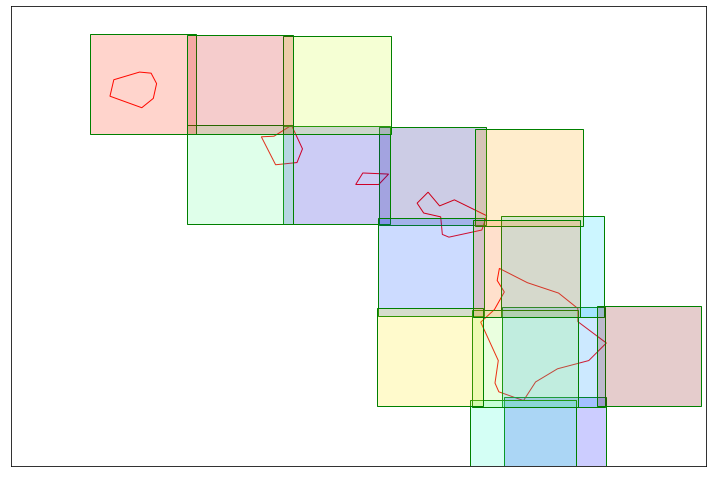

In [43]:
show_splitter(tile_splitter)

Obtained Sentinel-2 tiles intersect each other. Therefore this splitter is only useful if we are analyzing data on level of original satellite tiles.

We can also specify to further split the satellite tiles.

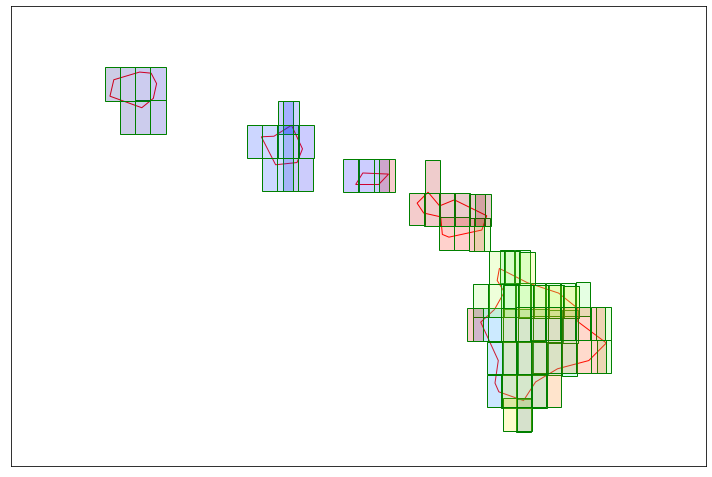

In [44]:
finer_tile_splitter = TileSplitter(
    [hawaii_area],
    CRS.WGS84,
    ("2017-10-01", "2018-03-01"),
    tile_split_shape=(7, 3),
    data_collection=DataCollection.SENTINEL2_L1C,
    config=config,
)

show_splitter(finer_tile_splitter, show_legend=False)

### Splitting in custom grid

In case none of the above splitters suffices there is also a `CustomGridSplitter`. All we need is a list of bounding boxes, which define a new way of splitting the area.

The following example is just a split into bounding boxes with integer value latitude and longitude:

In [45]:
bbox_grid = [BBox((x, y, x + 1, y + 1), CRS.WGS84) for x, y in itertools.product(range(-159, -155), range(18, 23))]

bbox_grid

[BBox(((-159.0, 18.0), (-158.0, 19.0)), crs=CRS('4326')),
 BBox(((-159.0, 19.0), (-158.0, 20.0)), crs=CRS('4326')),
 BBox(((-159.0, 20.0), (-158.0, 21.0)), crs=CRS('4326')),
 BBox(((-159.0, 21.0), (-158.0, 22.0)), crs=CRS('4326')),
 BBox(((-159.0, 22.0), (-158.0, 23.0)), crs=CRS('4326')),
 BBox(((-158.0, 18.0), (-157.0, 19.0)), crs=CRS('4326')),
 BBox(((-158.0, 19.0), (-157.0, 20.0)), crs=CRS('4326')),
 BBox(((-158.0, 20.0), (-157.0, 21.0)), crs=CRS('4326')),
 BBox(((-158.0, 21.0), (-157.0, 22.0)), crs=CRS('4326')),
 BBox(((-158.0, 22.0), (-157.0, 23.0)), crs=CRS('4326')),
 BBox(((-157.0, 18.0), (-156.0, 19.0)), crs=CRS('4326')),
 BBox(((-157.0, 19.0), (-156.0, 20.0)), crs=CRS('4326')),
 BBox(((-157.0, 20.0), (-156.0, 21.0)), crs=CRS('4326')),
 BBox(((-157.0, 21.0), (-156.0, 22.0)), crs=CRS('4326')),
 BBox(((-157.0, 22.0), (-156.0, 23.0)), crs=CRS('4326')),
 BBox(((-156.0, 18.0), (-155.0, 19.0)), crs=CRS('4326')),
 BBox(((-156.0, 19.0), (-155.0, 20.0)), crs=CRS('4326')),
 BBox(((-156.0

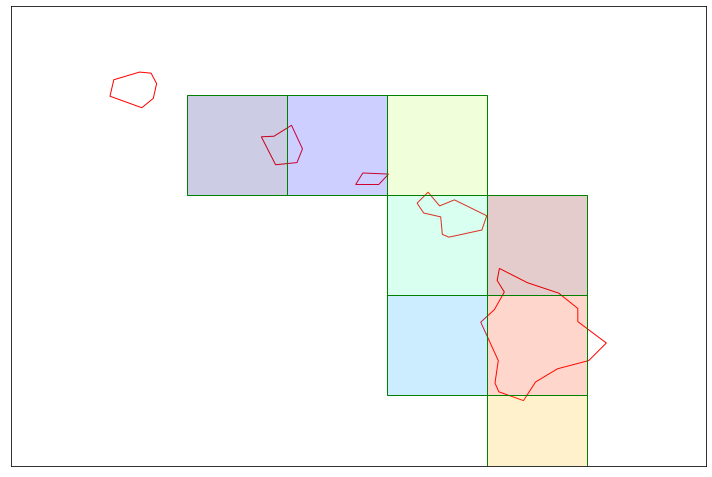

In [46]:
custom_grid_splitter = CustomGridSplitter([hawaii_area], CRS.WGS84, bbox_grid)

show_splitter(custom_grid_splitter)

Note that polygons, which are outside of the given collection of bounding boxes, will not affect the tiling.

Just like in previous examples we can further split each of the bounding boxes and reduce their size to better fit given shapes.

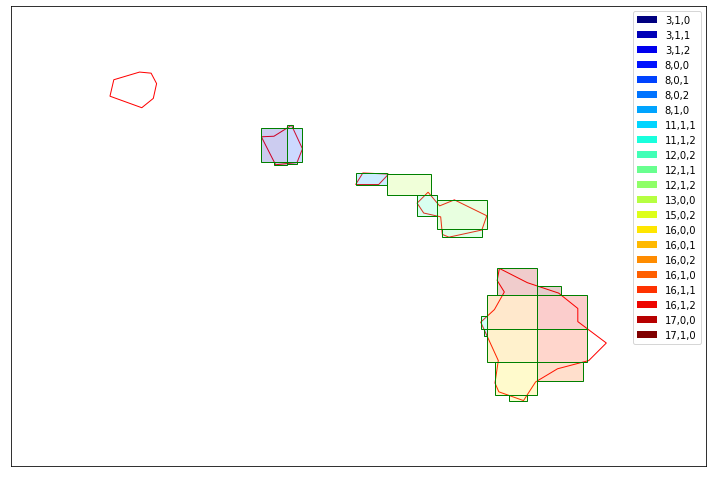

In [47]:
finer_custom_grid_splitter = CustomGridSplitter(
    [hawaii_area], CRS.WGS84, bbox_grid, bbox_split_shape=(2, 3), reduce_bbox_sizes=True
)

show_splitter(finer_custom_grid_splitter, show_legend=True)

### Splitting into UTM grid zones

When dealing with large areas such as countries or continents spanning multiple UTM zones, it might be convenient to split the area according to UTM zones or to the UTM Military Grid Reference System. For these use-cases, a `UtmZoneSplitter` and a `UtmGridSplitter` have been created. These splitters will generate a list of bounding boxes **in UTM CRS**. Each `BBox` will have the CRS corresponding to the UTM zone it belongs to. 

To ensure consistency across zones and grid tiles, the size of the `BBox`es in metres is specified as input parameter. For this reason, the option `reduce_bbox_sizes` is not available for these splitters. The two splitters return consistent results between each other, with the exceptions of areas where the UTM grid tiles present exceptions, as in `31V` and `32V`, and `31X`, `33X`, `35X` and `37X`. 

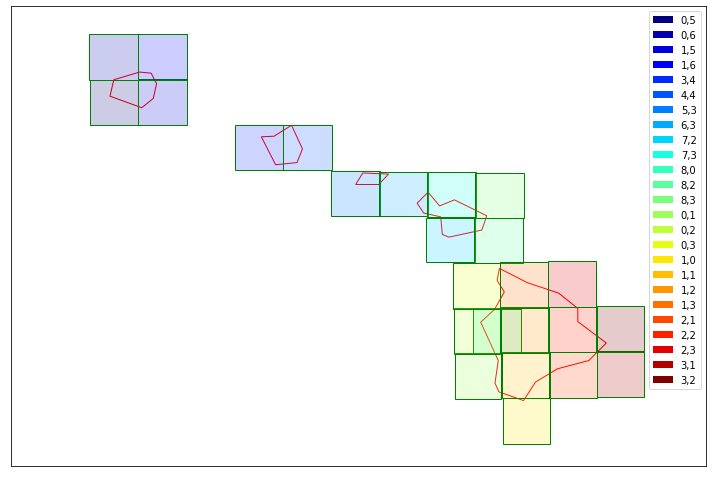

In [48]:
utm_zone_splitter = UtmZoneSplitter([hawaii_area], CRS.WGS84, (50000, 50000))

show_splitter(utm_zone_splitter, show_legend=True)

In [49]:
utm_zone_splitter.get_bbox_list()

[BBox(((400000.0, 2400000.0), (450000.0, 2450000.0)), crs=CRS('32604')),
 BBox(((400000.0, 2450000.0), (450000.0, 2500000.0)), crs=CRS('32604')),
 BBox(((450000.0, 2400000.0), (500000.0, 2450000.0)), crs=CRS('32604')),
 BBox(((450000.0, 2450000.0), (500000.0, 2500000.0)), crs=CRS('32604')),
 BBox(((550000.0, 2350000.0), (600000.0, 2400000.0)), crs=CRS('32604')),
 BBox(((600000.0, 2350000.0), (650000.0, 2400000.0)), crs=CRS('32604')),
 BBox(((650000.0, 2300000.0), (700000.0, 2350000.0)), crs=CRS('32604')),
 BBox(((700000.0, 2300000.0), (750000.0, 2350000.0)), crs=CRS('32604')),
 BBox(((750000.0, 2250000.0), (800000.0, 2300000.0)), crs=CRS('32604')),
 BBox(((750000.0, 2300000.0), (800000.0, 2350000.0)), crs=CRS('32604')),
 BBox(((800000.0, 2150000.0), (850000.0, 2200000.0)), crs=CRS('32604')),
 BBox(((800000.0, 2250000.0), (850000.0, 2300000.0)), crs=CRS('32604')),
 BBox(((800000.0, 2300000.0), (850000.0, 2350000.0)), crs=CRS('32604')),
 BBox(((150000.0, 2100000.0), (200000.0, 2150000.0)

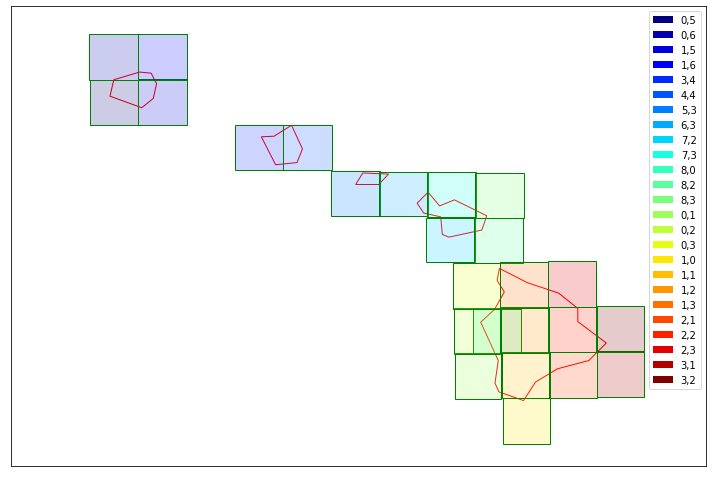

In [50]:
utm_grid_splitter = UtmGridSplitter([hawaii_area], CRS.WGS84, (50000, 50000))

show_splitter(utm_grid_splitter, show_legend=True)

### Download data from the bounding boxes using sentinelhub-py

As we can see, with the large area utilities we can easily create the bounding boxes around the desired areas. Next we are going to get the data for Kauai island (upper left), that is composed by 4 bounding boxes, to show how we can combine these utilities with the multithreaded download tools.

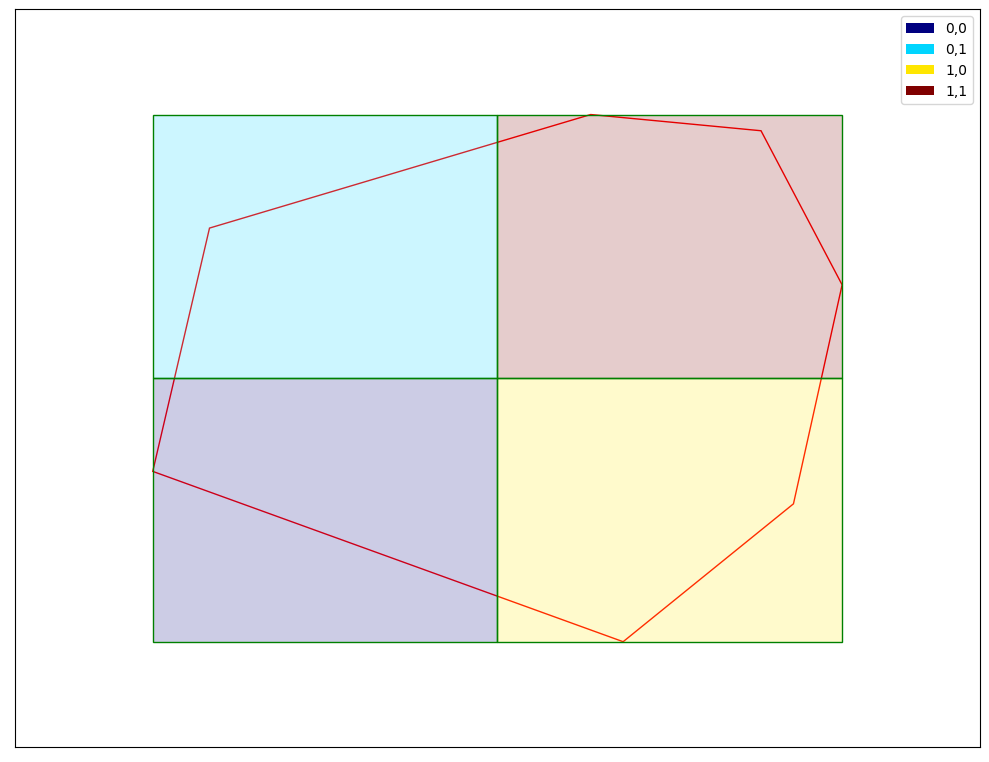

In [53]:
kauai = hawaii_area.geoms[-1]
kauai_split = BBoxSplitter([kauai], CRS.WGS84, (2, 2))
show_splitter(kauai_split, show_legend=True)

We will use an NDVI evalscript to get example data.

In [20]:
ndvi_eval = """
//VERSION=3

function evaluatePixel(samples) {
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1
    }
  }
}
"""

This is a helper function which returns a `SentinelHubRequest` for a specified bounding box. This is then applied to all bounding boxes, thus returning a list of `SentinelHubRequest`s each with a different specified bounding box.

We save the requested TIFF files in a temporary folder, but it can be specified to another location in case it is needed.

In [25]:
def get_subarea(bbox):
    return SentinelHubRequest(
        evalscript=ndvi_eval,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=("2020-10-01", "2022-10-13"),
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=(1250, 1250),
        data_folder=tempfile.gettempdir(),
        config=config,
    )

In [45]:
# create a list of requests
bbox_list = kauai_split.get_bbox_list()
sh_requests = [get_subarea(bbox) for bbox in bbox_list]
dl_requests = [request.download_list[0] for request in sh_requests]

# download data with multiple threads
downloaded_data = SentinelHubDownloadClient(config=config).download(dl_requests, max_threads=5)

Once the data is downloaded, we retreive all paths to the downloaded tiles.

In [30]:
data_folder = sh_requests[0].data_folder
tiffs = [Path(data_folder) / req.get_filename_list()[0] for req in sh_requests]

Then opening all tiles with `rioxarray` we mosaic the full image and plot it. Be aware though that plotting might query a lot of data if there are many large tiles. This can be very slow and consume a lot of resources.

An alternative would be to combine the tiles using the GDAL command line function `gdalbuildvrt` and optionally building overviews using `gdaladdo` so that the data can be displayed quicker at different scales.

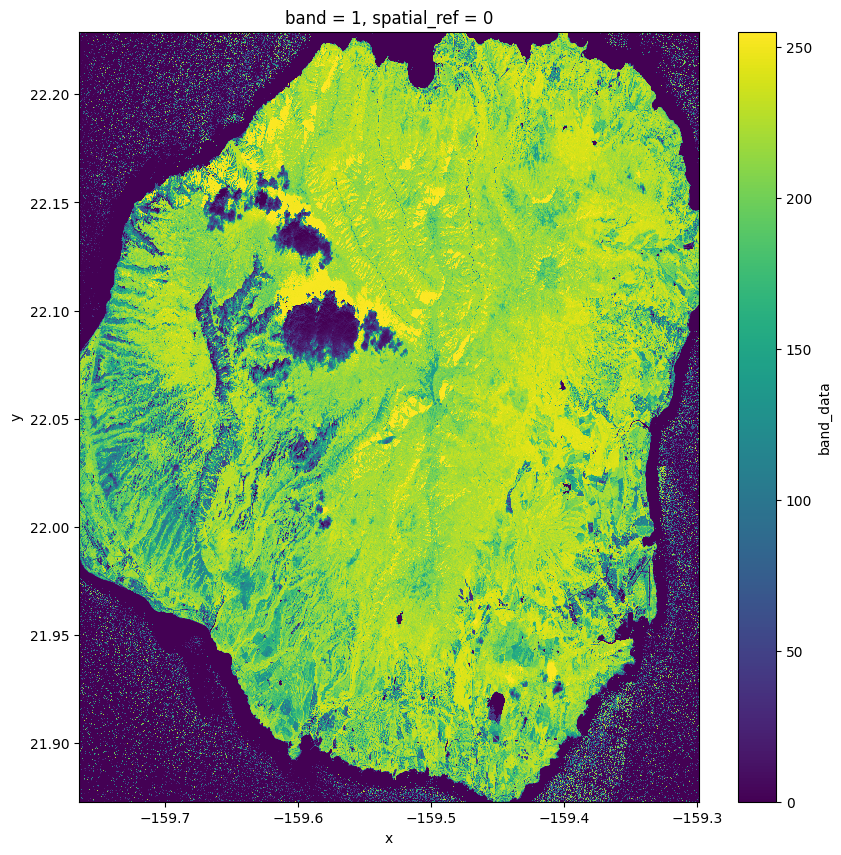

In [58]:
composed_tiff = xr.open_mfdataset(tiffs, engine="rasterio")
composed_tiff.band_data.isel(band=0).plot(figsize=(10, 10))

Finally to visualize the bounding boxes as well we can draw the original bounding boxes over our raster.

In [56]:
def plot_xr_and_vector(data_array, geo_vector):
    fig, ax = plt.subplots(figsize=(10, 10))
    data_array.plot(ax=ax)
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    geo_vector.plot(ax=ax, edgecolor="red", facecolor="none")

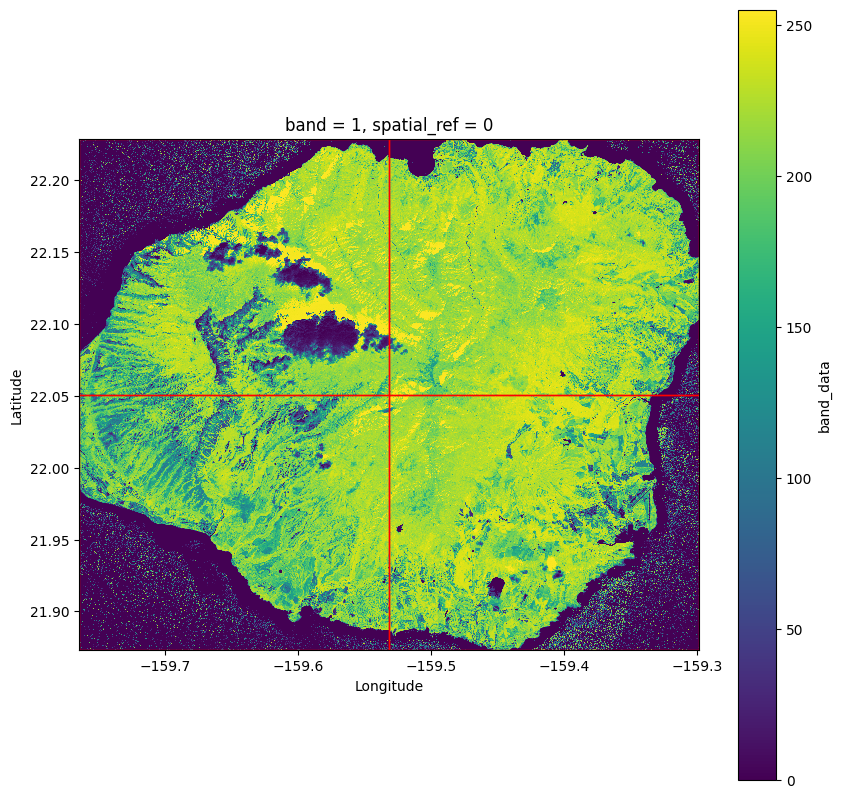

In [57]:
kauai_gpd = gpd.GeoDataFrame(geometry=[box(*bbox) for bbox in bbox_list], crs=4326)
plot_xr_and_vector(composed_tiff.band_data, kauai_gpd)

These separate tiles can be used well in further analysis with the [eo-learn](https://eo-learn.readthedocs.io/en/latest/) package. They can for example be ingested using the [ImportFromTiffTask](https://eo-learn.readthedocs.io/en/latest/reference/eolearn.io.raster_io.html#eolearn.io.raster_io.ImportFromTiffTask).

`eo-learn` is well suited to manage large scale and complex earth observation workflows. It does this by splitting up tasks into smaller chunks which makes large scale analysis available even with restricted resources.